# AE 370 Project 2 Main Notebook
### The damped wave equation of a string

This notebook demonstrates the method, and compares it to a known solution and investigates temporal and spatial error convergence.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip, AudioClip
from IPython.display import Audio, Video, display, clear_output
from ipywidgets import (
    FloatSlider, IntSlider, Dropdown, IntText, HTML,
    Button, HBox, VBox, Play, jslink, Output, Label
)
from scipy.linalg import solve_banded

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



In [ ]:
# Exact solution (only for sine wave ICs)
def u_exact(x, t, L, c, m, alpha):
    """
    Exact normal-mode solution of the damped 1D wave equation:

        u_tt + 2*alpha*u_t = c^2 u_xx

    with fixed ends. Underdamped case alpha < m*pi*c/L.
    """
    omega = m * np.pi * c / L             # natural frequency
    Omega = np.sqrt(omega**2 - alpha**2)  # damped frequency

    spatial = np.sin(m * np.pi * x / L)
    temporal = np.exp(-alpha * t) * np.cos(Omega * t)

    return spatial * temporal

# For 349.23 HZ (F4) on the e string of a guitar
f = 349.23
c = 504.9 # material constant for the e string of a guitar
L = c / (2.0 * f)

# Default Parameters
class Parameters:
    L = L #m
    c = 504.9 #m/s
    T = 3.0 #s
    fs_audio = 44100
    N_target = 500
    ic_type = "pluck"
    pluck_pos = 0.2
    pluck_amplitude = 0.5
    velocity_pos = 0.2
    mode_number = 3
    pickup_pos = 0.1
    alpha = 3.0
parameters = Parameters()

In [ ]:
# Method

# Implicit trapezoidal finite-difference solve
def string_simulate(
    L=parameters.L,
    c=parameters.c,
    T=parameters.T,
    fs_audio=parameters.fs_audio,
    N_target=parameters.N_target,
    ic_type=parameters.ic_type,
    pluck_pos=parameters.pluck_pos,
    pluck_amplitude=parameters.pluck_amplitude,
    velocity_pos=parameters.velocity_pos,
    mode_number=parameters.mode_number,
    pickup_pos=parameters.pickup_pos,
    alpha=parameters.alpha,
):
    """
    1D string solver for

        u_tt + 2*alpha*u_t = c^2 u_xx,  0 < x < L

    with fixed ends u(0,t)=u(L,t)=0.

    Parameters
    ----------
    L : float
        String length.
    c : float
        Wave speed.
    T : float
        Total simulation time.
    fs_audio : int
        Audio sampling rate (sets dt = 1/fs_audio).
    N_target : int
        Target number of spatial intervals (may be reduced by CFL).
    ic_type : {"pluck", "mode", "velocity"}
        Type of initial displacement.
    pluck_pos : float
        Pluck position (fraction of length) if ic_type="pluck".
    pluck_amplitude : float
        Pluck amplitude if ic_type="pluck".
    mode_number : int
        Mode number if ic_type="mode".
    pickup_pos : float
        Position where we record the signal (fraction of length).
    alpha : float
        Damping coefficient in 1/s; 0 = undamped.

    Returns
    -------
    x : ndarray, shape (N+1,)
        Spatial grid.
    t_audio : ndarray
        Time samples.
    audio : ndarray
        Recorded displacement at pickup (normalized).
    snapshots : ndarray, shape (num_snapshots, N+1)
        Snapshots of u(x,t) over time.
    t_snap : ndarray
        Times corresponding to snapshots.
    """
    dt = 1.0 / fs_audio
    n_steps = int(T / dt)
    if n_steps < 3:
        raise ValueError("T too small for chosen fs_audio.")
    max_frames = int(30 * T)

    N = N_target

    # Spatial grid
    x = np.linspace(0.0, L, N + 1)
    dx = L / N

    # Initial conditions
    u = np.zeros_like(x)
    v = np.zeros_like(x)

    if ic_type == "pluck":
        xp = pluck_pos * L
        left = x <= xp
        right = x > xp
        if xp > 0:
            u[left] = x[left] / xp
        if L > xp:
            u[right] = (L - x[right]) / (L - xp)
        u *= pluck_amplitude
        # v stays zero
    elif ic_type == "mode":
        u = np.sin(mode_number * np.pi * x / L)
        # v stays zero
    elif ic_type == "velocity":
        # Zero displacement, localized initial velocity
        xv = velocity_pos * L
        jp_vel = int(round(xv / dx))
        jp_vel = max(1, min(N - 1, jp_vel))  # interior index

        amplitude = 0.5
        v[jp_vel] = amplitude
        if jp_vel > 0:
            v[jp_vel - 1] = amplitude * 0.5
        if jp_vel < N:
            v[jp_vel + 1] = amplitude * 0.5
    else:
        raise ValueError("ic_type must be 'pluck', 'mode', or 'velocity'")

    # Enforce 0 displacement BC at ends
    u[0] = u[-1] = 0.0
    v[0] = v[-1] = 0.0

    # Initial acceleration
    a = np.zeros_like(x)
    u_xx = np.zeros_like(x)
    u_xx[1:-1] = (u[2:] - 2.0*u[1:-1] + u[:-2]) / dx**2
    a[1:-1] = c**2 * u_xx[1:-1] - 2.0 * alpha * v[1:-1]

    lam = c * dt / dx
    gamma = lam**2  # c^2 dt^2 / dx^2
    M = N - 1     # number of interior points

    # Set up banded A matrix
    A = np.zeros((3, M))
    main_diag = (4.0 + 4.0 * alpha * dt + 2.0 * gamma) * np.ones(M)
    off_diag  = -gamma * np.ones(M - 1)
    A[0, 1:] = off_diag
    A[1, :] = main_diag
    A[2, :-1] = off_diag

    # Interior points
    u_int = u[1:-1].copy()
    v_int = v[1:-1].copy()
    a_int = a[1:-1].copy()

    # Pickup index
    jp = int(round(pickup_pos * L / dx))
    jp = max(1, min(N - 1, jp))

    # Audio buffer
    audio = np.zeros(n_steps)
    audio[0] = u[jp]

    # Snapshots (ensure final time is included)
    k_snapshots = max(n_steps // max_frames, 1)
    snapshots = [u.copy()]
    t_snap = [0.0]

    # Implicit time stepping trapezoid
    for n in range(n_steps - 1):
        rhs = (
            a_int * dt**2
            + 2.0 * alpha * dt * (dt * v_int + 2.0 * u_int)
            + 4.0 * dt * v_int
            + 4.0 * u_int
        )

        # Solve for interior nodes u^{n+1}
        u_int_next = solve_banded((1,1), A, rhs)

        # Fix ends
        u_next = np.zeros_like(u)
        u_next[1:-1] = u_int_next

        # Update acceleration
        a_int_next = (
            -a_int * dt**2 - 4.0 * dt * v_int - 4.0 * u_int + 4.0 * u_int_next
        ) / dt**2

        # Update velocity
        v_int_next = v_int + 0.5 * dt * (a_int + a_int_next)

        # Increment u
        u_int, v_int, a_int = u_int_next, v_int_next, a_int_next
        u[1:-1] = u_int
        v[1:-1] = v_int

        # Audio
        audio[n+1] = u[jp]

        # Snapshots
        if (n + 1) % k_snapshots == 0:
            snapshots.append(u.copy())
            t_snap.append((n+1)*dt)

    # Ensure final time snapshot is included
    final_t = (n_steps - 1) * dt
    if t_snap[-1] < final_t - 1e-12:
        snapshots.append(u.copy())
        t_snap.append(final_t)

    # Normalize audio
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio /= max_val

    snapshots = np.vstack(snapshots)
    t_snap = np.array(t_snap)
    t_audio = np.linspace(0.0, dt*(n_steps-1), n_steps)

    return x, t_audio, audio, snapshots, t_snap

In [ ]:
# Visualization and interaction functions
figsize = (7, 3)
dpi = 100

def string_visualize(x, snapshots, t_snap):
    """
    Interactive plot using ipywidgets.
    """
    n_frames = snapshots.shape[0]
    y_min = -1.2
    y_max = 1.2

    out = Output()

    frame_slider = IntSlider(
        value=0,
        min=0,
        max=n_frames - 1,
        step=1,
        description="Frame",
        continuous_update=True,
        readout=True,
    )

    play = Play(
        value=0,
        min=0,
        max=n_frames - 1,
        step=1,
        interval=25,
        description="Play",
        disabled=False,
    )

    jslink((play, "value"), (frame_slider, "value"))

    def update_frame(k):
        with out:
            out.clear_output(wait=True)
            y = snapshots[k]
            if not np.all(np.isfinite(y)):
                print(f"Frame {k}: non-finite data, skipping plot.")
                return
            fig, ax = plt.subplots(figsize=figsize,dpi=dpi)
            ax.plot(x, y, lw=2)
            ax.set_xlabel("x (m)")
            ax.set_ylabel("Displacement")
            ax.set_title(f"t = {t_snap[k]:.4f} s")
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)
            ax.set_ylim(y_min, y_max)
            display(fig)
            plt.close(fig)

    def on_value_change(change):
        update_frame(change["new"])

    frame_slider.observe(on_value_change, names="value")
    controls = HBox([play, frame_slider])
    display(VBox([controls, out]))
    update_frame(0)


# Video
def string_video(
    x,
    snapshots,
    t_snap,
    audio,
    fs_audio,
    filename="string_with_audio.mp4",
):
    """
    Create an MP4 video of the vibrating string with synchronized audio.

    Fix: we take the audio duration as ground truth and set
    fps = n_frames / duration_audio so that video_duration == audio_duration.
    """
    audio_np = audio.astype(np.float32)
    duration_audio = len(audio_np) / float(fs_audio)

    n_frames = snapshots.shape[0]
    if duration_audio <= 0 or n_frames < 2:
        raise ValueError("Not enough data to build a meaningful video.")

    # FPS chosen so that video covers exactly the audio duration
    fps = n_frames / duration_audio
    #print(f"Using fps = {fps:.2f}, audio duration = {duration_audio:.3f} s")

    # y-limits for consistent axis
    ymin = -1.2
    ymax = 1.2

    # Render frames
    frames = []
    for k in range(n_frames):
        # Map frame index to "video time" for title
        t_frame = (k / (n_frames - 1)) * duration_audio

        fig, ax = plt.subplots(figsize=figsize,dpi=dpi)
        ax.plot(x, snapshots[k], lw=2)
        ax.set_xlim(x[0], x[-1])
        ax.set_ylim(ymin, ymax)
        ax.set_xlabel("x (m)")
        ax.set_ylabel("Displacement")
        ax.set_title(f"t \u2248 {t_frame:.4f} s")
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
        fig.subplots_adjust(bottom=0.2)
        fig.canvas.draw()
        buf = fig.canvas.renderer.buffer_rgba()
        img_rgba = np.asarray(buf, dtype=np.uint8)
        img_rgb = img_rgba[..., :3]
        frames.append(img_rgb)
        plt.close(fig)

    # Build video clip; its duration will be n_frames / fps = duration_audio
    clip = ImageSequenceClip(frames, fps=fps)

    # Build audio clip
    def audio_func(t):
        t = np.array(t, dtype=float)
        idx = (t * fs_audio).astype(int)
        idx = np.clip(idx, 0, len(audio_np) - 1)
        return audio_np[idx]

    audio_clip = AudioClip(audio_func, duration=duration_audio, fps=fs_audio)
    clip = clip.set_audio(audio_clip)

    #print(f"Writing {filename} ...")
    clip.write_videofile(filename, fps=fps, codec="libx264", audio_codec="aac", verbose=False, logger=None)
    #print("Done.")
    return filename

# Interactive simulation
def string_interactive():
    """
    Interactive sliders for the simple damped string model,
    with buttons to run the simulation and generate a video with audio.
    """
    # Widgets
    L_w =               FloatSlider(value=parameters.L, min=0.5, max=2.0, step=0.1, description="L (m)")
    c_w =               FloatSlider(value=parameters.c, min=20.0, max=1000.0, step=10.0, description="c (m/s)")
    T_w =               FloatSlider(value=parameters.T, min=0.2, max=5.1, step=0.1, description="T (s)")
    alpha_w =           FloatSlider(value=parameters.alpha, min=0.0, max=10.0, step=0.1,description="alpha (damp)")
    pluck_pos_w =       FloatSlider(value=parameters.pluck_pos, min=0.05, max=0.95, step=0.05,description="Pluck x/L")
    pluck_amplitude_w = FloatSlider(value=parameters.pluck_amplitude, min=0.0, max=1.0, step=0.05,description="Pluck Amplitude")
    velocity_pos_w =    FloatSlider(value=parameters.velocity_pos, min=0.05, max=0.95, step=0.05,description="Velocity x/L")
    pickup_pos_w =      FloatSlider(value=parameters.pickup_pos, min=0.1, max=0.9, step=0.05,description="Pickup x/L")
    fs_w =              Dropdown(options=[8000, 16000, 22050, 44100, 96000],value=parameters.fs_audio, description="fs (Hz)")
    ic_w =              Dropdown(options=[("Pluck (Displacement IC)", "pluck"), ("Velocity pulse (Velocity IC)", "velocity"), ("Mode shape (Displacement IC)", "mode")],value=parameters.ic_type, description="IC")
    mode_n_w =          IntSlider(value=parameters.mode_number, min=1, max=10, step=1, description="Mode n")
    N_target_w =        IntSlider(value=parameters.N_target, min=50, max=1000, step=25,description="N")
    video_id_w =        IntText(value=1, description="Video #")

    run_btn = Button(description="Run simulation", button_style="primary")
    video_btn = Button(description="Generate video", button_style="success")

    sim_out = Output()
    video_out = Output()

    # State shared between run + video
    state = {"x": None, "snapshots": None, "t_snap": None,
             "audio": None, "fs": None}

    def on_run_clicked(b):
        with sim_out:
            clear_output(wait=True)
            try:
                print("Running simulation...")
                x, t_audio, audio, snapshots, t_snap = string_simulate(
                    L=L_w.value,
                    c=c_w.value,
                    T=T_w.value,
                    fs_audio=int(fs_w.value),
                    N_target=int(N_target_w.value),
                    ic_type=ic_w.value,
                    pluck_pos=pluck_pos_w.value,
                    pluck_amplitude=pluck_amplitude_w.value,
                    velocity_pos=velocity_pos_w.value,
                    mode_number=int(mode_n_w.value),
                    pickup_pos=pickup_pos_w.value,
                    alpha=alpha_w.value,
                    #max_frames=max_frames_calculated
                )
                dx = x[1] - x[0]
                dt = t_audio[1] - t_audio[0]
                print(f"Grid: N = {len(x)-1}, dx = {dx:.3e}, dt = {dt:.3e}")
                #print(f"Snapshots stored: {snapshots.shape[0]}")

                # Save for video
                state["x"] = x
                state["snapshots"] = snapshots
                state["t_snap"] = t_snap
                state["audio"] = audio
                state["fs"] = int(fs_w.value)

                string_visualize(x, snapshots, t_snap)
                print("Audio:")
                display(Audio(audio, rate=int(fs_w.value)))
            except Exception as e:
                print("Error during simulation:", e)

    def on_video_clicked(b):
        with video_out:
            clear_output(wait=True)
            if (state["x"] is None) or (state["snapshots"] is None):
                print("Run a simulation first.")
                return
            try:
                vid_name = f"string_with_audio_{video_id_w.value}.mp4"
                fname = string_video(
                    state["x"],
                    state["snapshots"],
                    state["t_snap"],
                    state["audio"],
                    state["fs"],
                    filename=vid_name,
                )
                print("Video:")
                display(Video(fname, embed=True))
            except Exception as e:
                print("Error generating video:", e)

    run_btn.on_click(on_run_clicked)
    video_btn.on_click(on_video_clicked)

    controls_box = VBox([
        HTML('<b>Physical Parameters</b>'),
        L_w, c_w, alpha_w, T_w,

        HTML('<b>Initial Conditions</b>'),
        ic_w, pluck_pos_w, pluck_amplitude_w,
        velocity_pos_w, mode_n_w, pickup_pos_w,

        HTML('<b>Simulation Parameters</b>'),
        fs_w, N_target_w,

        HTML('<b>Generate Simulation</b>'),
        run_btn,

        HTML('<b>Generate Video (Run Simulation First)</b>'),
        video_id_w, video_btn
    ])

    ui = VBox([
        controls_box,
        sim_out,
        video_out
    ])
    display(ui)

In [ ]:
string_interactive()

In [ ]:
# Helper functions for error

# Get closest simulation time to desired evaluation time
def u_num_time(snapshots, t_snap, t_eval):
    """
    Return the numerical solution snapshot closest to t_eval.
    """
    k = np.argmin(np.abs(t_snap - t_eval))
    return snapshots[k, :], t_snap[k]

# Error
def error(u_num, u_true, x, normalized=True):
    """
    L2 relative error on the grid x,
    given numerical and exact solutions at the same time.

    ||e|| = ||u_num - u_true|| / ||u_true||
    """
    dx = x[1] - x[0]
    if normalized:
        num = np.sqrt(np.sum((u_num - u_true)**2) * dx)
        den = np.sqrt(np.sum(u_true**2) * dx)
    else:
        num = np.linalg.norm(u_num - u_true)
        den = np.linalg.norm(u_true)

    if den == 0.0:
        return np.nan
    return num / den


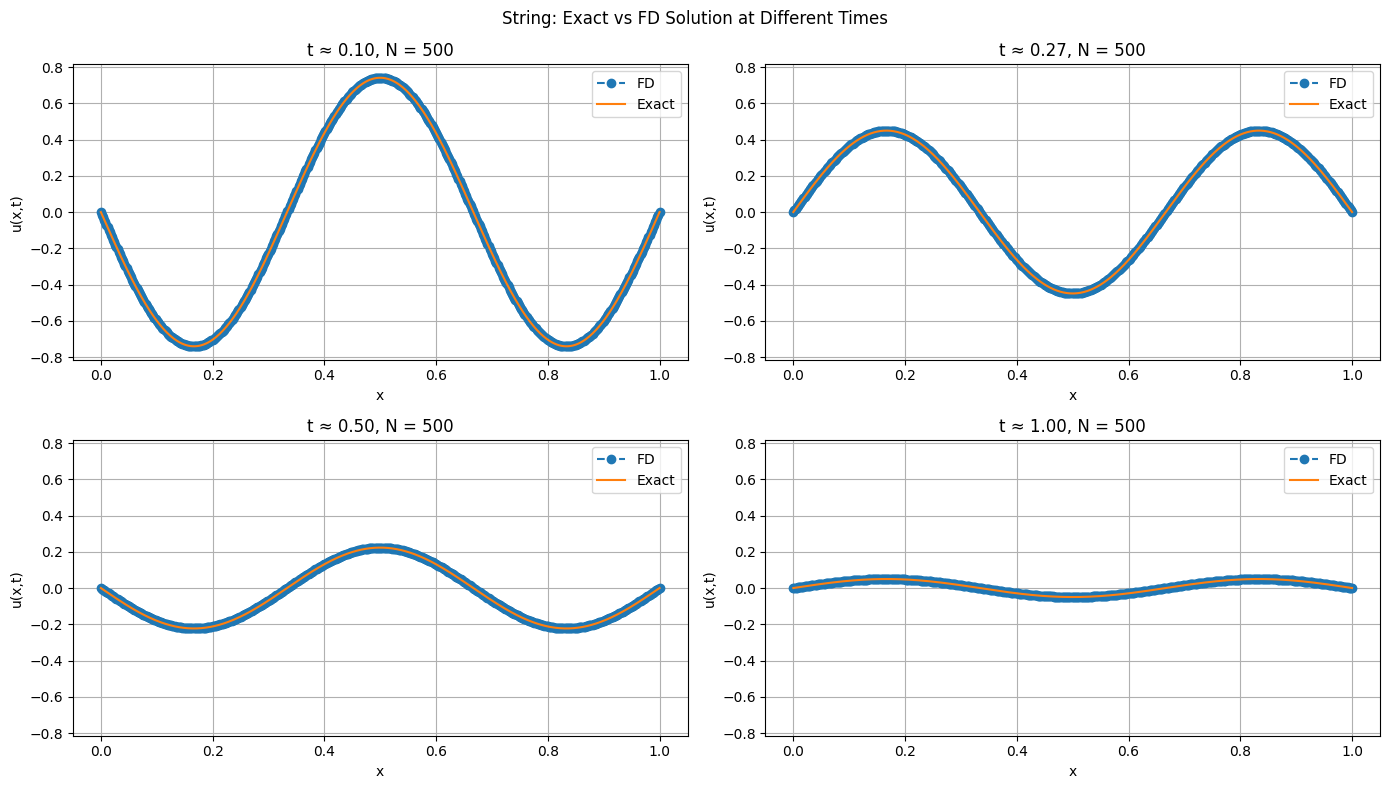

In [ ]:
# Exact vs Numerical at various times

# These error solutions take forever to run (this cell takes 45 seconds)
L = 1.0
c = 150
mode_number = 3
alpha_test = 3.0
T_test = 2.0

# Choose small dx and small dt
N_plot = 500             # dx = L/N_plot
fs_audio_plot = 196000   # dt = 1/fs_audio_plot

times_to_plot = [0.1, 0.25, 0.5, 1.0]  # choose times within [0, T_test]x

x_plot, t_audio_plot, audio_plot, snapshots_plot, t_snap_plot = string_simulate(
    L=L,
    c=c,
    T=T_test,
    fs_audio=fs_audio_plot,
    N_target=N_plot,
    ic_type="mode",
    pluck_pos=parameters.pluck_pos,
    pluck_amplitude=parameters.pluck_amplitude,
    velocity_pos=parameters.velocity_pos,
    mode_number=mode_number,
    pickup_pos=parameters.pickup_pos,
    alpha=alpha_test
)

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for i, t_plot in enumerate(times_to_plot):
    ax = axs[i]
    u_num, t_used = u_num_time(snapshots_plot, t_snap_plot, t_plot)
    u_true_vals = u_exact(x_plot, t_used, L, c, mode_number, alpha_test)

    ax.plot(x_plot, u_num, 'o--', label='FD')
    ax.plot(x_plot, u_true_vals, '-', label='Exact')
    ax.set_title(f't ≈ {t_used:.2f}, N = {N_plot}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.legend(loc='best')
    ax.grid(True)
    if i == 0:
        ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax)

fig.suptitle('String: Exact vs FD Solution at Different Times')
plt.tight_layout()
plt.show()

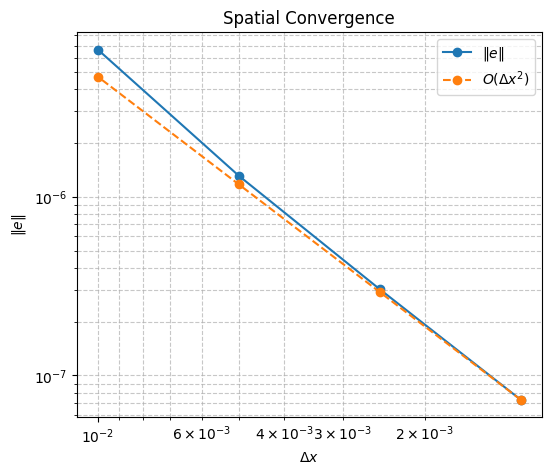

In [ ]:
# Spatial convergence (this cell takes 2 minutes)
L = 1.0
c = 150
mode_number = 1
alpha_test = 1
T_test = 0.1

N_ref_time = 8000
fs_audio_ref = 2000000
# Reference solution on fine spatial grid with small dt_ref
x_ref, t_audio_ref, audio_ref, snapshots_ref, t_snap_ref = string_simulate(
    L=L,
    c=c,
    T=T_test,
    fs_audio=fs_audio_ref,
    N_target=N_ref_time,
    ic_type="mode",
    pluck_pos=parameters.pluck_pos,
    pluck_amplitude=parameters.pluck_amplitude,
    velocity_pos=parameters.velocity_pos,
    mode_number=mode_number,
    pickup_pos=parameters.pickup_pos,
    alpha=alpha_test,
)

# Reference displacement at T_test
u_ref, t_ref_used = u_num_time(snapshots_ref, t_snap_ref, T_test)

fs_audio_space = 2000000

# Test grids
N_values = [100, 200, 400, 800]
errors_space = []
dx_values = []

for N_target in N_values:
    x_n, t_audio_n, audio_n, snapshots_n, t_snap_n = string_simulate(
        L=L,
        c=c,
        T=T_test,
        fs_audio=fs_audio_space,
        N_target=N_target,
        ic_type="mode",
        pluck_pos=parameters.pluck_pos,
        pluck_amplitude=parameters.pluck_amplitude,
        velocity_pos=parameters.velocity_pos,
        mode_number=mode_number,
        pickup_pos=parameters.pickup_pos,
        alpha=alpha_test
    )
    dx = x_n[1] - x_n[0]

    # Extract numerical solution at T_test on coarse grid
    u_num, t_used = u_num_time(snapshots_n, t_snap_n, T_test)

    # 2a) Interpolate reference solution from x_ref (fine) onto x_t (coarse)
    # If N_ref_time == N_coarse_time, this interpolation effectively becomes identity.
    u_ref_on_coarse = np.interp(x_n, x_ref, u_ref)

    # 2b) Error relative to reference (same spatial locations)
    err_x = error(u_num, u_ref_on_coarse, x_n)
    errors_space.append(err_x)
    dx_values.append(dx)

dx_values = np.array(dx_values)
errors_space = np.array(errors_space)

# 3) Build O(dt^2) reference line (sorted dt)
sort_idx = np.argsort(dx_values)
dx_sorted = dx_values[sort_idx]
err_sorted = errors_space[sort_idx]

ref_space = err_sorted[0] * (dx_sorted / dx_sorted[0])**2

plt.figure(figsize=(6, 5))
plt.loglog(dx_sorted, err_sorted, 'o-', label=r'$\|e\|$')
plt.loglog(dx_sorted, ref_space, 'o--', label=r'$O(\Delta x^2)$')
plt.xlabel(r'$\Delta x$')
plt.ylabel(r'$\|e\|$')
plt.title(r'Spatial Convergence')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()
plt.show()

Effective N_ref: 8000
Reference time used: t_ref_used = 0.099999


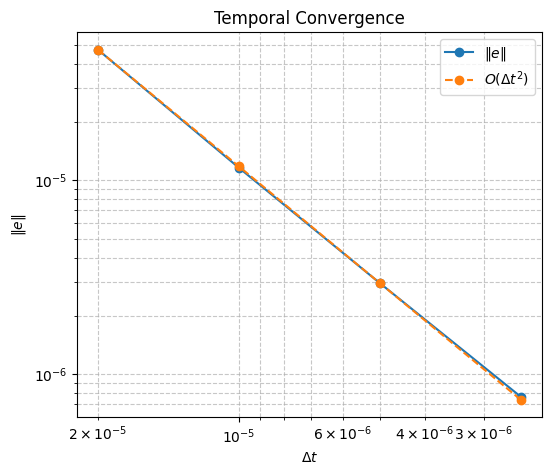

In [ ]:
# Temporal convergence (this cell takes 2 minutes)
L = 1.0
c = 150
mode_number = 1
alpha_test = 1
T_test = 0.1

# Coarse spatial grid for convergence runs
N_coarse_time = 2000

# Finer spatial grid for reference run
N_ref_time = 8000

# Time steps via fs_audio
fs_audio_values = np.array([50000, 100000, 200000, 400000])
dt_values = 1.0 / fs_audio_values

# Reference time step
fs_audio_ref = 2000000
dt_ref = 1.0 / fs_audio_ref


# 1) Reference solution on fine spatial grid with small dt_ref
x_ref, t_audio_ref, audio_ref, snapshots_ref, t_snap_ref = string_simulate(
    L=L,
    c=c,
    T=T_test,
    fs_audio=fs_audio_ref,
    N_target=N_ref_time,
    ic_type="mode",
    pluck_pos=parameters.pluck_pos,
    pluck_amplitude=parameters.pluck_amplitude,
    velocity_pos=parameters.velocity_pos,
    mode_number=mode_number,
    pickup_pos=parameters.pickup_pos,
    alpha=alpha_test,
)

N_eff_ref = len(x_ref) - 1

# Reference displacement at T_test
u_ref, t_ref_used = u_num_time(snapshots_ref, t_snap_ref, T_test)

errors_time = []
dt_list = []

# 2) Loop over dt values on spatial grid
for fs in fs_audio_values:
    dt = 1.0 / fs

    x_t, t_audio_t, audio_t, snapshots_t, t_snap_t = string_simulate(
        L=L,
        c=c,
        T=T_test,
        fs_audio=fs,
        N_target=N_coarse_time,
        ic_type="mode",
        pluck_pos=parameters.pluck_pos,
        pluck_amplitude=parameters.pluck_amplitude,
        velocity_pos=parameters.velocity_pos,
        mode_number=mode_number,
        pickup_pos=parameters.pickup_pos,
        alpha=alpha_test,
    )

    N_eff = len(x_t) - 1

    # Extract numerical solution at T_test on coarse grid
    u_num, t_used = u_num_time(snapshots_t, t_snap_t, T_test)

    # 2a) Interpolate reference solution from x_ref (fine) onto x_t (coarse)
    # If N_ref_time == N_coarse_time, this interpolation effectively becomes identity.
    u_ref_on_coarse = np.interp(x_t, x_ref, u_ref)

    # 2b) Error relative to reference (same spatial locations)
    err_t = error(u_num, u_ref_on_coarse, x_t)
    errors_time.append(err_t)
    dt_list.append(dt)

errors_time = np.array(errors_time)
dt_list = np.array(dt_list)

# 3) Build O(dt^2) reference line (sorted dt)
sort_idx = np.argsort(dt_list)
dt_sorted = dt_list[sort_idx]
err_sorted = errors_time[sort_idx]

ref_line = err_sorted[-1] * (dt_sorted / dt_sorted[-1])**2

plt.figure(figsize=(6, 5))
plt.loglog(dt_sorted, err_sorted, 'o-', label=r'$\|e\|$')
plt.loglog(dt_sorted, ref_line, 'o--', label=r'$O(\Delta t^2)$')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'$\|e\|$')
plt.title(r'Temporal Convergence')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()
plt.show()
